In [1]:
import numpy as np
import pandas as pd
import vectorbt as vbt
import seaborn as sns 
import matplotlib.pyplot as plt
import pandas_ta as ta
import yfinance as yf 
import warnings
warnings.filterwarnings('ignore')
plt.style.use('ggplot')
%matplotlib inline

In [2]:
df = pd.read_csv('2022.2.9BTCUSDT-H1-NoSession.csv')
df.Date = df.Date.astype(str)+' '+ df.Time
df.Date = pd.to_datetime(df.Date)
df.drop(columns= ['Time'], inplace = True)
df = df.set_index('Date')

In [3]:
#initial
def set_up_df(df:pd.DataFrame , index):  
    df1    =   pd.DataFrame(columns=index)
    df1['date']  =    df.index 
    df1.date = pd.to_datetime(df1.date,format='%Y-%m-%d')
    df1 = df1.set_index('date')
    return df1

#for calculate duration
def convert_to_hours(delta):
    total_seconds = delta.total_seconds()
    hours = str(int(total_seconds // 3600))
    return hours

#Performance Matric
def cal_consecutive(df:pd.DataFrame):
    df['win']= np.sign(df) # assign sign on log
    blocks = df['win'].ne(df['win'].shift()).cumsum() 
    df['consecutive_WL'] = df['win'].groupby(blocks).cumsum()
    return df['consecutive_WL'] 

def Cal_portstat(port):
    port_return = port.total_return().to_frame()
    port_return['MaxDD'] = port.max_drawdown()
    port_return['NumTrade'] = port.trades.count()
    port_return['WinRate'] = port.trades.win_rate()
    port_return['AvgWinningTrade'] = port.trades.winning.returns.mean()
    port_return['AvgLosingTrade'] = port.trades.losing.returns.mean()
    port_return['SharpRatio'] = port.returns_acc.sharpe_ratio()
    return port_return

def Cal_pip(df):
    pip = []
    pipp = df['Avg Exit Price'] - df['Avg Entry Price']
    for i in portfinal['Direction']:
        if i == 'Long':
            pip.append(1)
        else :
            pip.append(-1)    
    return (pip * pipp) 

def Cal_mae_mfe(data,port):
    MAE = []
    MFE = []
    for i,j,y,k in zip(port['Entry Timestamp'], port['Exit Timestamp'], port['Avg Entry Price'], port['Direction']):
        if k == 'Long':
            MFE.append((data.loc[i:j]['High'].max() - y)/y)
            MAE.append((y - df.loc[i:j]['Low'].min())/y)
        else :
            MAE.append((data.loc[i:j]['High'].max() - y)/y)
            MFE.append((y - df.loc[i:j]['Low'].min())/y)
    return MAE, MFE 

def Calkelly(port, init_cash = 10000):
    W = port.stats()[15]/100
    A = abs(port.stats()[19])
    B = port.stats()[18]
    Percent_kelly = (W/A) - ((1-W)/B)
    riskpertrade = Percent_kelly * init_cash
    print(f'Percent_kelly = {Percent_kelly}')
    

#### Donchian Strategy Default Parameter

In [4]:
lower = df.ta.donchian(28,28)['DCL_28_28']
mid = df.ta.donchian(28,28)['DCM_28_28']
upper = df.ta.donchian(28,28)['DCU_28_28']
    
    #define Signal
long_signal = (upper > upper.shift())
short_signal = (lower < lower.shift())
long_exit = short_signal
short_exit = long_signal
    
LongEntries = long_signal
LongExit= long_exit      
ShortEntries= short_signal
ShortExit= short_exit

port = vbt.Portfolio.from_signals(df.Close,
                                    entries = LongEntries,
                                    exits = LongExit,
                                    short_entries = ShortEntries,
                                    short_exits = ShortExit,
                                    freq = 'H',
                                    init_cash = 10000,
                                    fees = 0.00,
                                    slippage = 0.00)
Calkelly(port)

Percent_kelly = 0.024640252492366413


In [5]:
port.stats()

Start                               2017-08-17 04:00:00
End                                 2022-02-03 00:00:00
Period                               1625 days 15:00:00
Start Value                                     10000.0
End Value                                  54288.551878
Total Return [%]                             442.885519
Benchmark Return [%]                         755.879438
Max Gross Exposure [%]                            100.0
Total Fees Paid                                     0.0
Max Drawdown [%]                              60.876785
Max Drawdown Duration                 467 days 21:00:00
Total Trades                                        837
Total Closed Trades                                 836
Total Open Trades                                     1
Open Trade PnL                              1162.913971
Win Rate [%]                                  35.047847
Best Trade [%]                                34.190166
Worst Trade [%]                              -13

In [6]:
port.value().vbt.plot() #equity curve

FigureWidget({
    'data': [{'showlegend': False,
              'type': 'scatter',
              'uid': 'e2a34…

#### SL Optimise

In [7]:
df['atr'] = df.ta.atr()
portstats = []
start, end, step = (1, 4, 0.1)
array = np.arange(start,end,step)
for i in array:
    multiply = i
    df['sl_stop'] = (df['atr'] * multiply) / df.Close
    port = vbt.Portfolio.from_signals(df.Close,
                                    entries = LongEntries,
                                    exits = LongExit,
                                    short_entries = ShortEntries,
                                    short_exits = ShortExit,
                                    freq = 'H',
                                    init_cash = 10000,
                                    fees = 0.00,
                                    slippage = 0.00,
                                    sl_stop = df['sl_stop']  
                                     )
    portstats.append(port.stats())
pd.DataFrame(portstats).sort_values('Sharpe Ratio',ascending=False).head(5)   

,Start,End,Period,Start Value,End Value,Total Return [%],Benchmark Return [%],Max Gross Exposure [%],Total Fees Paid,Max Drawdown [%],...,Avg Winning Trade [%],Avg Losing Trade [%],Avg Winning Trade Duration,Avg Losing Trade Duration,Profit Factor,Expectancy,Sharpe Ratio,Calmar Ratio,Omega Ratio,Sortino Ratio
5,2017-08-17 04:00:00,2022-02-03,1625 days 15:00:00,10000.0,99506.819652,895.068197,755.879438,100.0,0.0,41.337275,...,5.674917,-1.977206,3 days 04:41:17.419354838,0 days 19:43:14.285714285,1.109772,96.878145,1.053398,1.633208,1.040785,1.530822
3,2017-08-17 04:00:00,2022-02-03,1625 days 15:00:00,10000.0,91597.159822,815.971598,755.879438,100.0,0.0,40.557003,...,5.714534,-1.843147,3 days 04:28:01.751824817,0 days 17:29:11.785714285,1.116865,84.849262,1.032973,1.588529,1.040636,1.502128
13,2017-08-17 04:00:00,2022-02-03,1625 days 15:00:00,10000.0,92723.411357,827.234114,755.879438,100.0,0.0,41.815802,...,5.691932,-2.319013,3 days 06:45:15.789473684,1 days 01:25:40.072202166,1.103962,96.230256,1.025746,1.551513,1.038136,1.482812
12,2017-08-17 04:00:00,2022-02-03,1625 days 15:00:00,10000.0,88716.943540,787.169435,755.879438,100.0,0.0,40.857403,...,5.680856,-2.288123,3 days 06:17:06.760563380,1 days 01:03:19.285714285,1.101193,91.014857,1.013862,1.548084,1.037838,1.466637
2,2017-08-17 04:00:00,2022-02-03,1625 days 15:00:00,10000.0,83260.724870,732.607249,755.879438,100.0,0.0,43.446457,...,5.774159,-1.780861,3 days 04:46:29.667896678,0 days 16:06:05.142857142,1.123053,74.203904,1.006490,1.402659,1.039911,1.461744


#### Improve with Volatility Stoploss

In [23]:
df['atr'] = df.ta.atr()
multiply = 1.5
df['sl_stop'] = (df['atr'] * multiply) / df.Close

lower = df.ta.donchian(28,28)['DCL_28_28']
mid = df.ta.donchian(28,28)['DCM_28_28']
upper = df.ta.donchian(28,28)['DCU_28_28']
    
#define Signal
long_signal = (upper > upper.shift())
short_signal = (lower < lower.shift())
long_exit = short_signal
short_exit = long_signal
    
LongEntries = long_signal
LongExit= long_exit      
ShortEntries= short_signal
ShortExit= short_exit

port = vbt.Portfolio.from_signals(df.Close,
                                    entries = LongEntries,
                                    exits = LongExit,
                                    short_entries = ShortEntries,
                                    short_exits = ShortExit,
                                    freq = 'H',
                                    init_cash = 10000,
                                    fees = 0.00,
                                    slippage = 0.00, sl_stop = df.sl_stop)
Calkelly(port)

Percent_kelly = 0.033106007648463526


In [24]:
port.stats()

Start                               2017-08-17 04:00:00
End                                 2022-02-03 00:00:00
Period                               1625 days 15:00:00
Start Value                                     10000.0
End Value                                  99506.819652
Total Return [%]                             895.068197
Benchmark Return [%]                         755.879438
Max Gross Exposure [%]                            100.0
Total Fees Paid                                     0.0
Max Drawdown [%]                              41.337275
Max Drawdown Duration                 240 days 14:00:00
Total Trades                                        910
Total Closed Trades                                 909
Total Open Trades                                     1
Open Trade PnL                               1444.58597
Win Rate [%]                                  30.693069
Best Trade [%]                                34.190166
Worst Trade [%]                                -

In [25]:
port.value().vbt.plot() #equity curve

FigureWidget({
    'data': [{'showlegend': False,
              'type': 'scatter',
              'uid': '39cf4…

#### improve with EMATrend and Volatility Stop

In [44]:
ema1 = df.ta.ema(50)
ema2 = df.ta.ema(200) 

df['atr'] = df.ta.atr()
multiply = 2.5
df['sl_stop'] = (df['atr'] * multiply) / df.Close

lower = df.ta.donchian(28,28)['DCL_28_28']
mid = df.ta.donchian(28,28)['DCM_28_28']
upper = df.ta.donchian(28,28)['DCU_28_28']
    
#define Signal
long_signal = (upper > upper.shift()) & (ema1>ema2)
short_signal = (lower < lower.shift()) & (ema1<ema2)
long_exit = (lower < lower.shift())
short_exit = (upper > upper.shift())
    
LongEntries = long_signal
LongExit= long_exit      
ShortEntries= short_signal
ShortExit= short_exit

size = (1000/df['sl_stop'])/ df.Close
port = vbt.Portfolio.from_signals(df.Close,
                                    entries = LongEntries,
                                    exits = LongExit,
                                    short_entries = ShortEntries,
                                    short_exits = ShortExit,
                                    freq = 'H',
                                    init_cash = 10000,
                                    fees = 0.00,size=size,
                                    slippage = 0.00, sl_stop = df.sl_stop)
Calkelly(port)

Percent_kelly = 0.04197188063855736


In [45]:
port.stats()

Start                               2017-08-17 04:00:00
End                                 2022-02-03 00:00:00
Period                               1625 days 15:00:00
Start Value                                     10000.0
End Value                                 145618.864394
Total Return [%]                            1356.188644
Benchmark Return [%]                         755.879438
Max Gross Exposure [%]                     14511.089171
Total Fees Paid                                     0.0
Max Drawdown [%]                              65.225149
Max Drawdown Duration                 189 days 07:00:00
Total Trades                                        486
Total Closed Trades                                 486
Total Open Trades                                     0
Open Trade PnL                                      0.0
Win Rate [%]                                  34.773663
Best Trade [%]                                34.190166
Worst Trade [%]                              -12

In [46]:
port.value().vbt.plot() #equity curve

FigureWidget({
    'data': [{'showlegend': False,
              'type': 'scatter',
              'uid': '634e8…

--------------------------

In [14]:
## Final Strategy
def Strategy_final(df) :
    ema1 = df.ta.ema(50)
    ema2 = df.ta.ema(200) 

    df['atr'] = df.ta.atr()
    multiply = 2.5
    df['sl_stop'] = (df['atr'] * multiply) / df.Close

    lower = df.ta.donchian(28,28)['DCL_28_28']
    mid = df.ta.donchian(28,28)['DCM_28_28']
    upper = df.ta.donchian(28,28)['DCU_28_28']

    #define Signal
    long_signal = (upper > upper.shift()) & (ema1>ema2)
    short_signal = (lower < lower.shift()) & (ema1<ema2)
    long_exit = (lower < lower.shift())
    short_exit = (upper > upper.shift())

    LongEntries = long_signal
    LongExit= long_exit      
    ShortEntries= short_signal
    ShortExit= short_exit

    port = vbt.Portfolio.from_signals(df.Close,
                                        entries = LongEntries,
                                        exits = LongExit,
                                        short_entries = ShortEntries,
                                        short_exits = ShortExit,
                                        freq = 'H',
                                        init_cash = 10000,
                                        fees = 0.00,
                                        slippage = 0.00, sl_stop = df.sl_stop)
    return port

### Trend Period (Low Volatility)

In [ ]:
df.loc[:'2021-02-01 20:00:00'].plot()

In [16]:
Strategy_final(df.loc[:'2021-02-01 20:00:00']).stats()

Start                               2017-08-17 04:00:00
End                                 2021-02-01 20:00:00
Period                               1260 days 00:00:00
Start Value                                     10000.0
End Value                                  98972.386378
Total Return [%]                             889.723864
Benchmark Return [%]                         685.167899
Max Gross Exposure [%]                            100.0
Total Fees Paid                                     0.0
Max Drawdown [%]                               41.64044
Max Drawdown Duration                 275 days 23:00:00
Total Trades                                        363
Total Closed Trades                                 362
Total Open Trades                                     1
Open Trade PnL                               914.670073
Win Rate [%]                                   34.80663
Best Trade [%]                                34.190166
Worst Trade [%]                              -12

In [17]:
Strategy_final(df.loc[:'2021-02-01 20:00:00']).value().vbt.plot()

FigureWidget({
    'data': [{'showlegend': False,
              'type': 'scatter',
              'uid': '5f98e…

In [18]:
df.loc[:'2021-02-01 20:00:00'].Close.vbt.plot() #Price

FigureWidget({
    'data': [{'name': 'Close',
              'showlegend': True,
              'type': 'scatter…

### Non-Trend Period (High Volatility)

<AxesSubplot:xlabel='Date'>

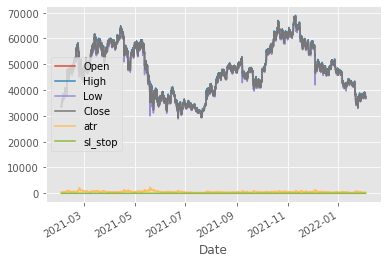

In [19]:
df.loc['2021-02-01 20:00:00':].plot()

In [20]:
Strategy_final(df.loc['2021-02-01 20:00:00':]).stats()

Start                               2021-02-01 20:00:00
End                                 2022-02-03 00:00:00
Period                                365 days 16:00:00
Start Value                                     10000.0
End Value                                    7951.18864
Total Return [%]                             -20.488114
Benchmark Return [%]                           9.005913
Max Gross Exposure [%]                            100.0
Total Fees Paid                                     0.0
Max Drawdown [%]                              40.164082
Max Drawdown Duration                 325 days 17:00:00
Total Trades                                        122
Total Closed Trades                                 122
Total Open Trades                                     0
Open Trade PnL                                      0.0
Win Rate [%]                                  33.606557
Best Trade [%]                                18.197921
Worst Trade [%]                               -5

In [21]:
Strategy_final(df.loc['2021-02-01 20:00:00':]).value().vbt.plot() #Equitycurve

FigureWidget({
    'data': [{'showlegend': False,
              'type': 'scatter',
              'uid': '6325e…

In [22]:
df.loc['2021-02-01 20:00:00':].Close.vbt.plot() #Price

FigureWidget({
    'data': [{'name': 'Close',
              'showlegend': True,
              'type': 'scatter…